In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from tqdm import tqdm  # Progress bar

import time

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler  # Standardizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # One hot Encoder
from scipy.sparse import csr_matrix  # For sparse matrix

from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR
# from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from sklearn import metrics


%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# drive_path="drive/MyDrive/"

In [3]:
drive_path="/home/dezs/projects/myIDS/datasets/"
model_path="/home/dezs/projects/myIDS/models/"

In [4]:
file_path = drive_path+"myDataset"
# Train and Test data
x_train, y_train = pickle.load(open(file_path+'/final_small_oversampled_train.pkl', 'rb'))
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Dictionaries
saved_infos = pickle.load(open(file_path+'/saved_infos.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Onehot encoders
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

label_encoder = pickle.load(open(file_path+'/label_encoder.pkl', 'rb'))


In [5]:
class_labels = label_encoder.classes_
print(class_labels)
encoded_values = label_encoder.transform(['analysis', 'backdoor', 'dos', 'exploits', 'fuzzers', 'generic', 'normal', 'reconnaissance', 'shellcode', 'worms'])
print(encoded_values)
mapping = dict(zip(class_labels, encoded_values))
print(mapping)

['analysis' 'backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal'
 'reconnaissance' 'shellcode' 'worms']
[0 1 2 3 4 5 6 7 8 9]
{'analysis': np.int64(0), 'backdoor': np.int64(1), 'dos': np.int64(2), 'exploits': np.int64(3), 'fuzzers': np.int64(4), 'generic': np.int64(5), 'normal': np.int64(6), 'reconnaissance': np.int64(7), 'shellcode': np.int64(8), 'worms': np.int64(9)}


In [6]:
x_test.shape

(617826, 48)

In [7]:
x_train.shape

(10000, 197)

## Pipeline functions

In [8]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list

    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"none" if x=="-" else x)

        # Fixing binary columns
        if col in saved_infos['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_infos['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)

    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
# def apply_log1p(data):
#     '''
#     Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
#     '''
#     for col in saved_infos['log1p_col']:
#         new_col = col + '_log1p'  # New col name
#         data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
#         data.drop(col, axis=1, inplace=True)  # Removing old columns
#     return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_infos['num_col']] = scaler.transform(data[saved_infos['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))

    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)

    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [9]:
def labelcoding(data):
    data= label_encoder.transform(data)
    return data

In [10]:
def get_final_data(data, saved_infos=saved_infos, mode_dict=mode_dict):
    '''
    This functions takes raw input and convert that to model required output.
    '''
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_infos['columns']

    data['network_bytes'] = data['dbytes'] + data['sbytes']

    dropable_col = saved_infos['to_drop'] + saved_infos['corr_col']
    data.drop(columns=dropable_col, inplace=True)

    data = clean_data(data)
    # data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)

    return data

In [11]:
ohe_service.categories_

[array(['dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'none', 'pop3',
        'radius', 'smtp', 'snmp', 'ssh', 'ssl'], dtype=object)]

In [12]:
# Using pipeline to prepare test data
x_test = get_final_data(x_test)

In [13]:
y_test=y_test.fillna(value="normal").apply(lambda x:x.strip().lower())
y_test = y_test.replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
y_test= labelcoding(y_test)
y_test = pd.DataFrame(y_test,columns=['attack_cat',],)
y_test=y_test['attack_cat']

In [14]:
x_train.shape, y_train.shape

((10000, 197), (10000,))

In [15]:
x_test.shape, y_test.shape

((617826, 197), (617826,))

In [16]:
train_columns = set(x_train.columns)
test_columns = set(x_test.columns)

# Find columns only in train
train_only_columns = train_columns - test_columns

# Find columns only in test
test_only_columns = test_columns - train_columns

print("Columns only in train:", train_only_columns)
print("Columns only in test:", test_only_columns)

Columns only in train: set()
Columns only in test: set()


In [17]:
all(x_train.columns == x_test.columns)

True

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def encode_attack_non_attack(df):
    #something broke, so i'm doing this, i'm tired
    df=pd.DataFrame(df)
    replace_values = [9, 8, 7, 5, 4, 3, 2, 1, 0]
    new_df = df.replace(replace_values, 1).replace(6, 0)
    return new_df


# def calculate_far(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     far = fp / (fp + tn)
#     return 0

# def false_alarm_rate(y_true, y_pred):
#     """
#     This function will return False Alarm Rate for given true and predicted values.
#     False Alarm Rate is average of False Negetive Rate and False Positive Rate
#     """
#     # return calculate_far(y_true, y_pred)
#     y_true=encode_attack_non_attack(y_true)
#     y_pred = encode_attack_non_attack(y_pred)

#     c_matrix=confusion_matrix(y_true, y_pred)
#     tn, fp, fn, tp = c_matrix.ravel()

#     labels= ['non-attack', 'attack']
#     plt.figure(figsize=(8, 6))  # Adjust figure size as needed
#     sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='d',xticklabels=labels, yticklabels=labels)  # Customize colors and format
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for General Attack Detection')
#     plt.show()
#     FPR = fp / (fp + tn)  # False positive rate
#     FNR = fn / (fn + tp)  # False negetive rate
#     return (FPR+FNR)/2  # False alarm rate


def evaluate_result(y_true, y_pred, model_name):
    # far=false_alarm_rate(y_true, y_pred)
    # test_f1 = f1_score(y_test, y_test_pred, average=None)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred,average='weighted')

    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

    x = PrettyTable()
    x.field_names = [ 'Accuracy','Precision','Recall','F1']
    x.add_row([accuracy,precision,recall,f1])
    print(x)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    # Create a heatmap with clear labels and annotations
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')  # Customize colors and format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    # cm_display.plot()
    # plt.show()

    # Returning scores
    return accuracy

In [19]:
# old_x_train=x_train
# old_y_train=y_train
# old_x_test=x_test
# old_y_test=y_test

In [20]:
# old_x_train.shape

In [21]:
# line_count=10000

# # x_train=old_x_train.head(line_count)
# # y_train=old_y_train.head(line_count)
# x_test=old_x_test.head(line_count)
# y_test=old_y_test.head(line_count)

In [22]:
x_test.shape

(617826, 197)

## Long term short term neural network

In [23]:
# sequence_length = 300
# batch_size = 128

# X_train_seq = pad_sequences( x_train, maxlen = sequence_length)
# X_test_seq = pad_sequences( x_test, maxlen = sequence_length)

In [24]:
# model = Sequential()

# model.add(e)

# model.add(LSTM( 128 , dropout = 0.25, recurrent_dropout = 0.25))

# model.add(Dense(1, activation = 'sigmoid' ))

# model.summary()

# model.compile( optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

# early_stopper = EarlyStopping( monitor = 'val_acc' , min_delta = 0.0005, patience = 3 )

# reduce_lr = ReduceLROnPlateau( monitor = 'val_loss' , patience = 2 , cooldown = 0)

# callbacks = [ reduce_lr , early_stopper]

# train_history = model.fit( X_train_seq , y_train , batch_size = batch_size, epochs = 5,validation_split = 0.1 , verbose = 1 , callbacks = callbacks)

# score = model.evaluate( X_test_seq , y_test , batch_size = batch_size)

# print( "Accuracy: {:0.4}".format( score[1] ))

# print( "Loss:", score[0] )

In [25]:
y_train.value_counts()

6    1000
3    1000
5    1000
4    1000
7    1000
2    1000
0    1000
1    1000
8    1000
9    1000
Name: count, dtype: int64

## No Parameter

## Decision Tree


In [26]:
start_time = time.time() 

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(x_train,y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 0.1429 seconds


In [27]:

start_time = time.time() 

dt_y_test_pred=dt_classifier.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 0.3519 seconds


+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+
| 0.9663772647962371 | 0.9821611048877648 | 0.9663772647962371 | 0.9730064454900594 |
+--------------------+--------------------+--------------------+--------------------+


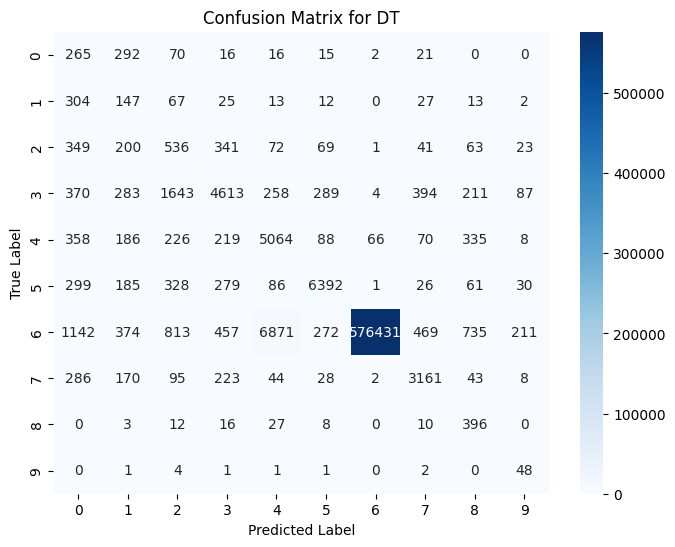

In [28]:
dt_acc =evaluate_result(y_test, dt_y_test_pred, 'DT')

In [29]:
with open(model_path+'my_dt.pkl', 'wb') as f:
    pickle.dump(dt_classifier, f)

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)

start_time = time.time() 
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(x_train,y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 0.2673 seconds


In [31]:

start_time = time.time() 

rf_y_test_pred=rf_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 1.6170 seconds


+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+
| 0.9698248374137702 | 0.9849205040963407 | 0.9698248374137702 | 0.9758711149780249 |
+--------------------+--------------------+--------------------+--------------------+


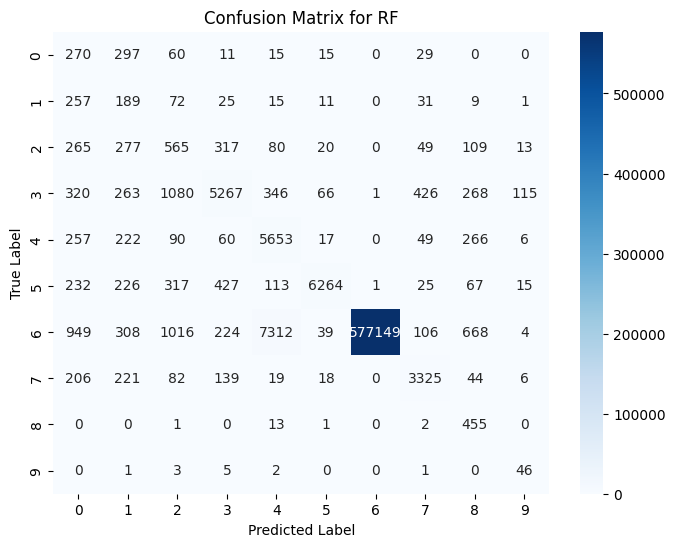

In [32]:
lr_acc =evaluate_result(y_test, rf_y_test_pred, 'RF')

In [33]:
with open(model_path+'my_rf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

## XGBoost

In [34]:
from xgboost import XGBClassifier
# read data
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# data = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance

start_time = time.time() 
bst = XGBClassifier(n_jobs=-1)
# fit model
bst.fit(x_train, y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 2.7259 seconds


In [35]:

start_time = time.time() 

xgb_y_test_pred=bst.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 1.3116 seconds


+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+
| 0.9690074551734631 | 0.9844229122381649 | 0.9690074551734631 | 0.9752806187908417 |
+--------------------+--------------------+--------------------+--------------------+


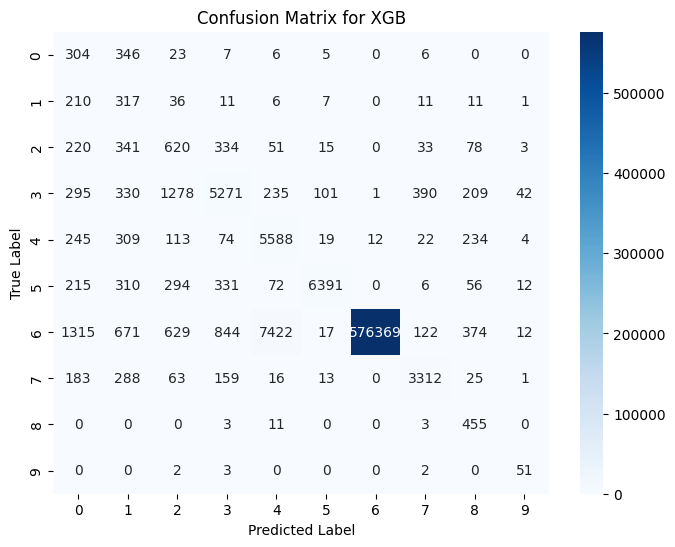

In [36]:
xgb_acc =evaluate_result(y_test, xgb_y_test_pred, 'XGB')

In [37]:
with open(model_path+'my_xgb.pkl', 'wb') as f:
    pickle.dump(bst, f)

## Hyperparameter Tuning

In [38]:
## DT
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion': ['gini', 'entropy','poisson']}

dt_model = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_model, param_grid, cv=5,n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy'}
Best score: 0.6656


In [39]:
# ##SVM
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# param_grid = {'kernel': ['rbf', 'poly', 'linear','sigmoid']}

# svm_model = SVC()

# grid_search = GridSearchCV(svm_model, param_grid, cv=5,n_jobs=-1)
# grid_search.fit(x_train, y_train)

# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization

In [41]:
def stratified_kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

In [42]:
# def bo_params_svm(C, gamma):
#     params = {
#         'C': C,
#         'gamma': gamma
#     }
#     clf = SVC(C=params['C'], kernel='linear', gamma=params['gamma'])
#     score = stratified_kfold_score(clf, x_train, y_train, 5)
#     return score



def bo_params_dt(max_depth, min_samples_split, min_samples_leaf):
    params = {
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf)
    }
    clf = DecisionTreeClassifier(**params)
    score = stratified_kfold_score(clf, x_train, y_train, 5)
    return score

def bo_params_rf(max_samples,n_estimators,max_features):
    
    params = {
        'max_samples': max_samples,
        'max_features':max_features,
        'n_estimators':int(n_estimators)
    }
    clf = RandomForestClassifier(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'], n_jobs=-1)
    score = stratified_kfold_score(clf,x_train, y_train,5)
    return score

def bo_params_xgb(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree 
    }
    clf = xgb.XGBClassifier(**params, n_jobs=-1)
    score = stratified_kfold_score(clf, x_train, y_train, 5)
    return score

In [43]:

# svm_bo = BayesianOptimization(bo_params_svm, {
#     'C': (0.1, 10.0),
#     # 'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
#     'gamma': (0.001, 10.0)
# })

dt_bo = BayesianOptimization(bo_params_dt, {
    'max_depth': (2, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
})

rf_bo = BayesianOptimization(bo_params_rf, {
    'max_samples':(0.5,1),
    'max_features':(0.5,1),
    'n_estimators':(100,200)
})


xgb_bo = BayesianOptimization(bo_params_xgb, {
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.1),
    'n_estimators': (100, 500),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
})

In [44]:
# params = svm_bo.max['params']
# params['C']= float(params['C'])
# params['gamma']= float(params['gamma'])
# print(params)

In [45]:
results={}
results['dt'] = dt_bo.maximize(n_iter=200, init_points=20)

|   iter    |  target   | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------
| 1         | 0.7002    | 8.569     | 1.729     | 17.15     |
| 2         | 0.4796    | 4.342     | 5.084     | 14.22     |
| 3         | 0.6266    | 6.238     | 1.308     | 19.17     |
| 4         | 0.7005    | 8.375     | 3.695     | 10.0      |
| 5         | 0.4796    | 4.412     | 8.712     | 10.55     |
| 6         | 0.7181    | 9.51      | 7.536     | 6.029     |
| 7         | 0.7002    | 8.875     | 1.009     | 7.18      |
| 8         | 0.6555    | 7.231     | 4.351     | 7.964     |
| 9         | 0.4796    | 4.589     | 7.828     | 4.03      |
| 10        | 0.6266    | 6.361     | 8.499     | 5.25      |
| 11        | 0.6999    | 8.671     | 7.869     | 10.22     |
| 12        | 0.5808    | 5.03      | 4.345     | 2.254     |
| 13        | 0.6266    | 6.907     | 8.482     | 7.028     |
| 14        | 0.6563    | 7.584     | 1.154     | 19.64     |
| 15    

In [46]:
all_params={}

In [47]:

params = dt_bo.max['params']

params['max_depth']= int(params['max_depth'])
params['min_samples_leaf']= int(params['min_samples_leaf'])
params['min_samples_split']= int(params['min_samples_split'])
print(params)
all_params['dt_params']=params

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [48]:
results['rf'] = rf_bo.maximize(n_iter=200, init_points=20)

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.7057    | 0.7716    | 0.9442    | 175.3     |
| 2         | 0.7044    | 0.9245    | 0.7694    | 178.0     |
| 3         | 0.7091    | 0.6232    | 0.8373    | 186.4     |
| 4         | 0.7061    | 0.7543    | 0.743     | 139.5     |
| 5         | 0.7071    | 0.6258    | 0.9555    | 191.6     |
| 6         | 0.708     | 0.5393    | 0.8221    | 172.8     |
| 7         | 0.7066    | 0.6801    | 0.6841    | 109.7     |
| 8         | 0.7086    | 0.6587    | 0.8084    | 140.1     |
| 9         | 0.7058    | 0.7341    | 0.5968    | 183.8     |
| 10        | 0.7073    | 0.77      | 0.8525    | 184.6     |
| 11        | 0.7076    | 0.7719    | 0.9266    | 110.4     |
| 12        | 0.7047    | 0.8946    | 0.7727    | 102.1     |
| 13        | 0.7081    | 0.7115    | 0.773     | 102.8     |
| 14        | 0.7046    | 0.8457    | 0.5824    | 146.6     |
| 15    

In [49]:
params = rf_bo.max['params']
params['max_samples']= float(params['max_samples'])
params['max_features']= float(params['max_features'])
params['n_estimators']= int(params['n_estimators'])
print(params)
all_params['rf_params']=params

{'max_features': 0.5106882856571591, 'max_samples': 0.7345010457917474, 'n_estimators': 186}


In [50]:
results['xgb'] = xgb_bo.maximize(n_iter=200, init_points=20)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.7207    | 0.7065    | 0.04543   | 2.319     | 192.1     | 0.8707    |
| 2         | 0.7273    | 0.8626    | 0.06778   | 7.765     | 336.7     | 0.9724    |
| 3         | 0.7449    | 0.7049    | 0.06718   | 3.039     | 389.1     | 0.9805    |
| 4         | 0.7421    | 0.8836    | 0.07592   | 3.724     | 128.0     | 0.803     |
| 5         | 0.7351    | 0.6199    | 0.06101   | 4.448     | 499.7     | 0.6767    |
| 6         | 0.736     | 0.7355    | 0.0729    | 4.182     | 374.6     | 0.6224    |
| 7         | 0.7267    | 0.8146    | 0.05155   | 2.237     | 246.4     | 0.9371    |
| 8         | 0.7468    | 0.8868    | 0.01617   | 4.876     | 467.8     | 0.8106    |
| 9         | 0.7414    | 0.7495    | 0.0912    | 4.142     | 207.1     | 0.6271    |
| 10        | 0.7184    | 0.9407    | 0.03756   | 9.92

In [53]:
params = xgb_bo.max['params']
params['colsample_bytree']= float(params['colsample_bytree'])
params['learning_rate']= float(params['learning_rate'])
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['subsample']= float(params['subsample'])
print(params)
all_params['xgb_params']=params

{'colsample_bytree': 0.7340141140025496, 'learning_rate': 0.05894200983938156, 'max_depth': 5, 'n_estimators': 135, 'subsample': 0.9222231281384863}


In [54]:
temp={}
for key,value in params.items():
    temp[key]=float(value)
temp

{'colsample_bytree': 0.7340141140025496,
 'learning_rate': 0.05894200983938156,
 'max_depth': 5.0,
 'n_estimators': 135.0,
 'subsample': 0.9222231281384863}

In [ ]:
# svc_params={'C': 8.876951085871351,'kernel':'linear', 'gamma': 6.251282342506629}
# dt_params={'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}
# rf_params={'max_features': 0.585664929515135, 'max_samples': 0.5998288751638163, 'n_estimators': 121}
# xgb_params={'colsample_bytree': 0.6419255804983351,
#  'learning_rate': 0.02368115203787831,
#  'max_depth': 7,
#  'n_estimators': 205,
#  'subsample': 0.9204170326972261}

## Decision Tree


In [95]:
start_time = time.time() 

dt_classifier = DecisionTreeClassifier(**all_params['dt_params'])
dt_classifier.fit(x_train,y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 0.1568 seconds


In [96]:

start_time = time.time() 

dt_y_test_pred=dt_classifier.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 0.3754 seconds


+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+
| 0.9666168144429014 | 0.9845646861710322 | 0.9666168144429014 | 0.9737745031470807 |
+--------------------+--------------------+--------------------+--------------------+


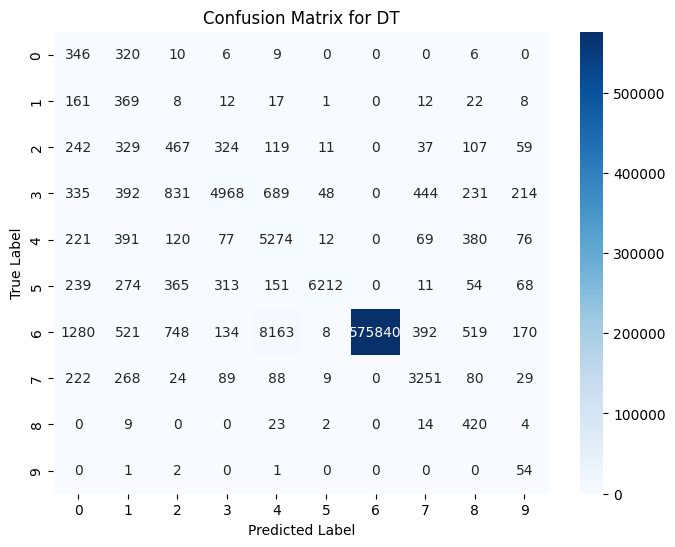

In [97]:
dt_acc =evaluate_result(y_test, dt_y_test_pred, 'DT')

In [58]:
with open(model_path+'my_dt.pkl', 'wb') as f:
    pickle.dump(dt_classifier, f)

## Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)

start_time = time.time() 
rf_clf = RandomForestClassifier(**all_params['rf_params'],n_jobs=-1)
rf_clf.fit(x_train,y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 1.3884 seconds


In [93]:

start_time = time.time() 

rf_y_test_pred=rf_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 2.9342 seconds


+--------------------+--------------------+--------------------+-------------------+
|      Accuracy      |     Precision      |       Recall       |         F1        |
+--------------------+--------------------+--------------------+-------------------+
| 0.9698555904089501 | 0.9848301053463452 | 0.9698555904089501 | 0.975889261779211 |
+--------------------+--------------------+--------------------+-------------------+


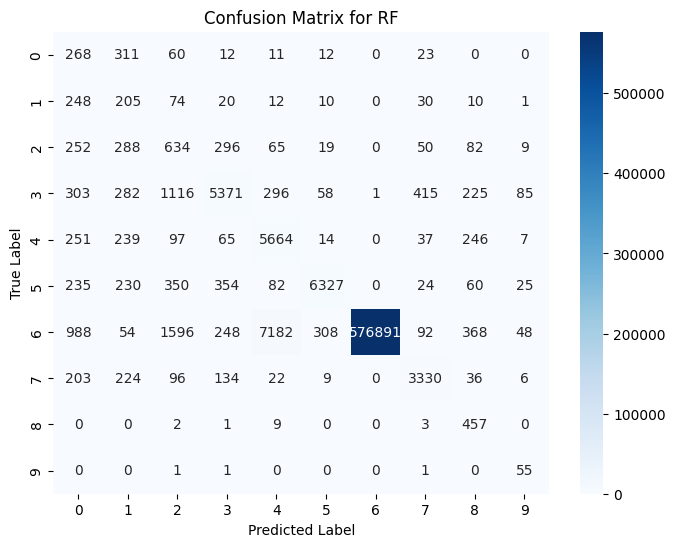

In [94]:
lr_acc =evaluate_result(y_test, rf_y_test_pred, 'RF')

In [62]:
with open(model_path+'my_rf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

## XGBoost

In [76]:
from xgboost import XGBClassifier
# read data
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# data = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance

start_time = time.time() 
bst = XGBClassifier(**all_params['xgb_params'],n_jobs=-1)
# fit model
bst.fit(x_train, y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 6.1779 seconds


In [77]:

start_time = time.time() 

xgb_y_test_pred=bst.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 1.4878 seconds


+-------------------+--------------------+-------------------+--------------------+
|      Accuracy     |     Precision      |       Recall      |         F1         |
+-------------------+--------------------+-------------------+--------------------+
| 0.969198447459317 | 0.9855602591254327 | 0.969198447459317 | 0.9757323792665908 |
+-------------------+--------------------+-------------------+--------------------+


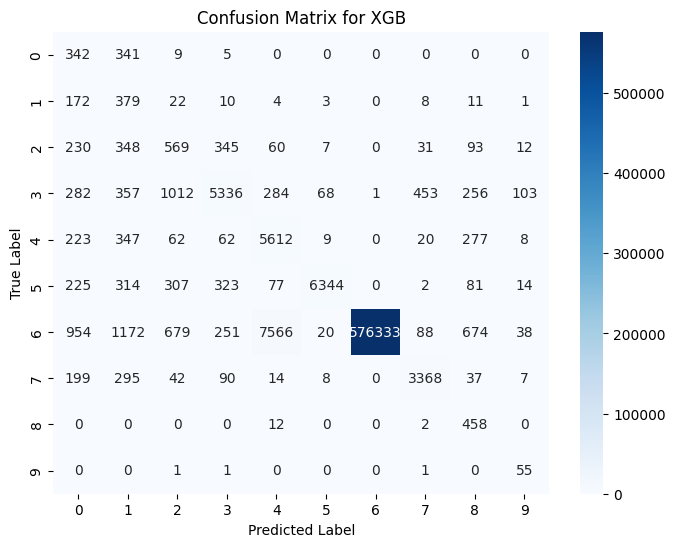

In [78]:
xgb_acc =evaluate_result(y_test, xgb_y_test_pred, 'XGB')

In [66]:
with open(model_path+'my_xgb.pkl', 'wb') as f:
    pickle.dump(bst, f)

In [ ]:
# all_params={'svc_params':svc_params,'dt_params':dt_params,'rf_params':rf_params,'xgb_params':xgb_params}

In [67]:
all_params

{'dt_params': {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3},
 'rf_params': {'max_features': 0.5106882856571591,
  'max_samples': 0.7345010457917474,
  'n_estimators': 186},
 'xgb_params': {'colsample_bytree': 0.7340141140025496,
  'learning_rate': 0.05894200983938156,
  'max_depth': 5,
  'n_estimators': 135,
  'subsample': 0.9222231281384863}}

In [68]:
with open(model_path+'my_params.pkl', 'wb') as f:
    pickle.dump(all_params, f)

In [71]:
test = pickle.load(open(model_path+'my_old_params.pkl', 'rb'))

In [72]:
test

{'svc_params': {'C': 8.876951085871351,
  'kernel': 'linear',
  'gamma': 6.251282342506629},
 'dt_params': {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4},
 'rf_params': {'max_features': 0.585664929515135,
  'max_samples': 0.5998288751638163,
  'n_estimators': 121},
 'xgb_params': {'colsample_bytree': 0.6419255804983351,
  'learning_rate': 0.02368115203787831,
  'max_depth': 7,
  'n_estimators': 205,
  'subsample': 0.9204170326972261}}

## Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier
# Initializing all the 3 classifiers with best found parameters

start_time = time.time() 
dt_clf = DecisionTreeClassifier(**my_params['dt_params'])
rf_clf = RandomForestClassifier(**my_params['rf_params'], n_jobs=-1)
xgb_clf = xgb.XGBClassifier(**my_params['xgb_params'], n_jobs=-1)
v_clf = VotingClassifier(estimators=[('lr', dt_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting='soft', n_jobs=-1)

v_clf.fit(x_train, y_train)

training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

In [ ]:
start_time = time.time() 

v_clf_y_test_pred=v_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

In [ ]:
v_clf_acc =evaluate_result(y_test, v_clf_y_test_pred, 'Ensemble Classifier')

In [ ]:
with open(model_path+'my_ensemble_clf.pkl', 'wb') as f:
    pickle.dump(v_clf, f)